In [ ]:
# fashion_mnist_pipeline.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import fashion_mnist
import joblib

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

X_norm = X / 255.0
X_flat = X_norm.reshape(X.shape[0], -1)

# PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_flat)
joblib.dump(pca, 'pca_model.pkl')

# KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_
joblib.dump(kmeans, 'kmeans_model.pkl')

# Evaluation
sil_score = silhouette_score(X_pca, labels)
inertia = kmeans.inertia_
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Inertia: {inertia:.2f}")

# DBSCAN
X_scaled = StandardScaler().fit_transform(X_pca[:, :10])
db = DBSCAN(eps=1.5, min_samples=10)
db_labels = db.fit_predict(X_scaled)
print(f"DBSCAN clusters found: {len(set(db_labels)) - (1 if -1 in db_labels else 0)}")

# Visualize clusters
sns.set(style="whitegrid")
df = pd.DataFrame({
    'pca1': X_pca[:, 0],
    'pca2': X_pca[:, 1],
    'label': y,
    'cluster': labels
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10', s=10)
plt.title("KMeans Clusters in PCA Space")
plt.savefig("clusters.png")
plt.close()

# Cluster interpretation
from collections import Counter
cluster_map = {}
for i in range(10):
    true_labels = y[labels == i]
    most_common = Counter(true_labels).most_common(1)[0][0]
    cluster_map[i] = most_common

print("Cluster to label map:", cluster_map)

# Save interpretation map
joblib.dump(cluster_map, 'cluster_map.pkl')


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Silhouette Score: 0.1813
Inertia: 1805386.61
DBSCAN clusters found: 1
Cluster to label map: {0: np.uint8(9), 1: np.uint8(8), 2: np.uint8(5), 3: np.uint8(1), 4: np.uint8(4), 5: np.uint8(6), 6: np.uint8(8), 7: np.uint8(9), 8: np.uint8(7), 9: np.uint8(0)}


['cluster_map.pkl']

In [ ]:
np.savez_compressed("fashion_mnist_data.npz", X=X_norm, y=y)

In [ ]:
from collections import Counter
import joblib

# Predict clusters for your PCA-transformed training set
clusters = kmeans.predict(X_pca)

# Create a mapping: cluster → most common true label
cluster_map = {}
for cluster_id in np.unique(clusters):
    indices = np.where(clusters == cluster_id)[0]
    true_labels = y[indices]
    most_common = Counter(true_labels).most_common(1)[0][0]
    cluster_map[cluster_id] = most_common

# Save the mapping
joblib.dump(cluster_map, 'cluster_map.pkl')


['cluster_map.pkl']

In [ ]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
for cluster_id, label in cluster_map.items():
    print(f"Cluster {cluster_id} → {class_names[label]}")


Cluster 0 → Ankle boot
Cluster 1 → Bag
Cluster 2 → Sandal
Cluster 3 → Trouser
Cluster 4 → Coat
Cluster 5 → Shirt
Cluster 6 → Bag
Cluster 7 → Ankle boot
Cluster 8 → Sneaker
Cluster 9 → T-shirt/top


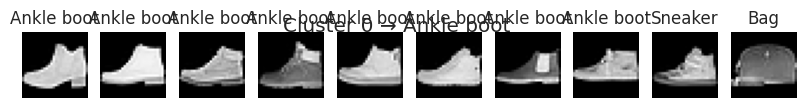

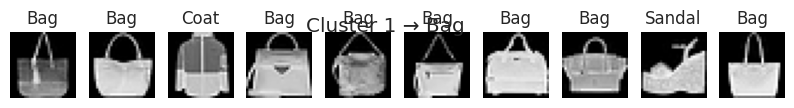

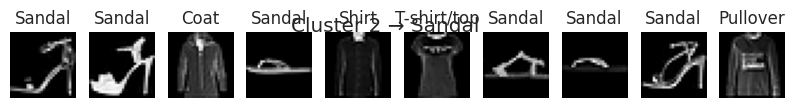

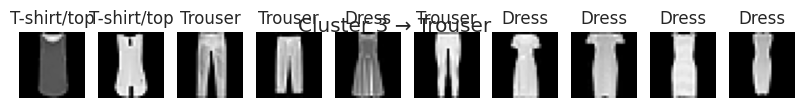

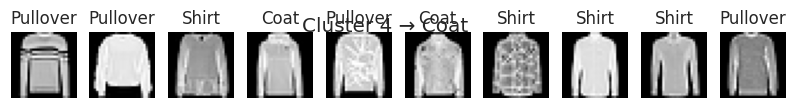

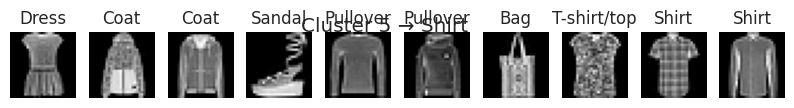

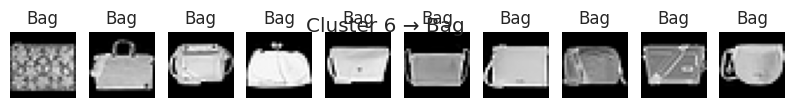

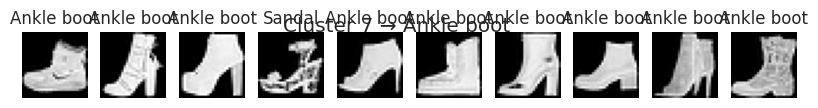

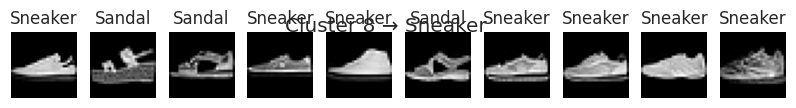

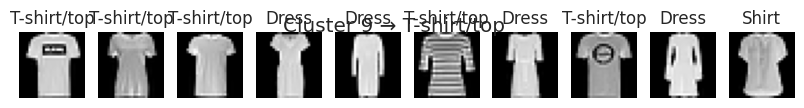

In [ ]:
# Visualize samples from each cluster
import matplotlib.pyplot as plt

for cluster_id in np.unique(clusters):
    idxs = np.where(clusters == cluster_id)[0][:10]
    plt.figure(figsize=(10, 1))
    for i, idx in enumerate(idxs):
        plt.subplot(1, 10, i + 1)
        plt.imshow(X[idx], cmap='gray')
        plt.axis('off')
        plt.title(class_names[y[idx]])
    plt.suptitle(f"Cluster {cluster_id} → {class_names[cluster_map[cluster_id]]}")
    plt.show()
